Generation 1: Best Fitness = 0.0083
Generation 2: Best Fitness = 0.0083
Generation 3: Best Fitness = 0.0083
Generation 4: Best Fitness = 0.0083
Generation 5: Best Fitness = 0.0097
Generation 6: Best Fitness = 0.0110
Generation 7: Best Fitness = 0.0123
Generation 8: Best Fitness = 0.0135
Generation 9: Best Fitness = 0.0135
Generation 10: Best Fitness = 0.0152
Generation 11: Best Fitness = 0.0175
Generation 12: Best Fitness = 0.0167
Generation 13: Best Fitness = 0.0182
Generation 14: Best Fitness = 0.0185
Generation 15: Best Fitness = 0.0200
Generation 16: Best Fitness = 0.0200
Generation 17: Best Fitness = 0.0154
Generation 18: Best Fitness = 0.0156
Generation 19: Best Fitness = 0.0179
Generation 20: Best Fitness = 0.0189
Generation 21: Best Fitness = 0.0169
Generation 22: Best Fitness = 0.0172
Generation 23: Best Fitness = 0.0147
Generation 24: Best Fitness = 0.0119
Generation 25: Best Fitness = 0.0135
Generation 26: Best Fitness = 0.0127
Generation 27: Best Fitness = 0.0127
Generation

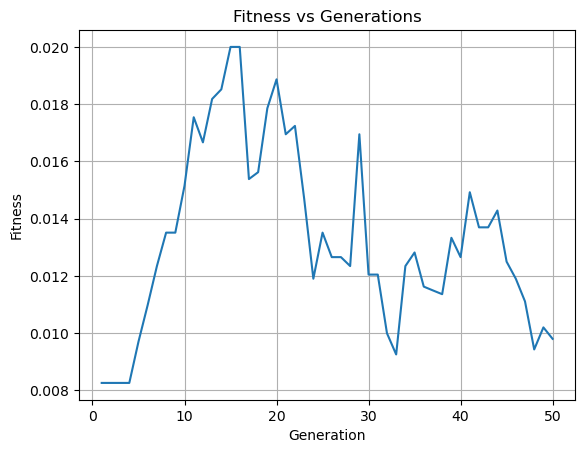

In [21]:
import random
import sqlite3
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt

# Database Connection and Data Fetching
def load_data():
    conn = sqlite3.connect("mydatabase.db")
    c = conn.cursor()
    try:
        c.execute("SELECT * FROM courses")
        courses = c.fetchall()
        c.execute("SELECT * FROM lecturers")
        lecturers = c.fetchall()
        c.execute("SELECT * FROM rooms")
        rooms = c.fetchall()
        c.execute("SELECT * FROM timeslots")
        timeslots = c.fetchall()
    except sqlite3.Error as e:
        print("Error loading data:", e)
        return None, None, None, None
    finally:
        conn.close()
    return courses, lecturers, rooms, timeslots


# Genetic Algorithm Parameters
POP_SIZE = 100
GENERATIONS = 50
MUTATION_RATE = 0.05
TOURNAMENT_SIZE = 5


# Initialize Chromosome
def create_chromosome(courses, lecturers, rooms, timeslots):
    return [[course, random.choice(lecturers), random.choice(rooms), random.choice(timeslots)] for course in courses]


# Initialize Population
def create_population(pop_size, courses, lecturers, rooms, timeslots):
    return [create_chromosome(courses, lecturers, rooms, timeslots) for _ in range(pop_size)]


# Fitness Function
def fitness(chromosome):
    hard_violations = 0
    soft_violations = 0

    for i, (course1, lecturer1, room1, timeslot1) in enumerate(chromosome):
        for j, (course2, lecturer2, room2, timeslot2) in enumerate(chromosome):
            if i == j:
                continue

            # Hard Constraints
            if lecturer1 == lecturer2 and timeslot1 == timeslot2:
                hard_violations += 1  # Lecturer conflict
            if room1 == room2 and timeslot1 == timeslot2:
                hard_violations += 1  # Room conflict
            if room1[2] < course1[4]:  # Room capacity constraint
                hard_violations += 1
            if course1[3] == course2[3] and timeslot1 == timeslot2:
                hard_violations += 1  # Student group conflict

            # Soft Constraints
            if timeslot1[1] != timeslot2[1]:
                time1 = timeslot1[2] + (12 if timeslot1[3] == "PM" else 0)
                time2 = timeslot2[2] + (12 if timeslot2[3] == "PM" else 0)
                gap = abs(time1 - time2)
                if gap >= 4:
                    soft_violations += 1

    return 1 / (1 + hard_violations + 0.5 * soft_violations)


# Crossover Function
def crossover(parents, segment_lengths):
    parent1, parent2 = parents
    child = []
    start = 0
    for length in segment_lengths:
        if random.random() < 0.5:
            child.extend(parent1[start : start + length])
        else:
            child.extend(parent2[start : start + length])
        start += length
    return child


# Mutation Function
def mutate(chromosome, timeslots):
    if random.random() < MUTATION_RATE:
        gene_index = random.randint(0, len(chromosome) - 1)
        chromosome[gene_index][3] = random.choice(timeslots)  # Mutate timeslot
    return chromosome


# Genetic Algorithm with Fitness Tracking
def genetic_algorithm(pop_size, generations, courses, lecturers, rooms, timeslots):
    population = create_population(pop_size, courses, lecturers, rooms, timeslots)
    fitness_history = []  # To store the best fitness value of each generation

    for generation in range(generations):
        # Evaluate Fitness
        population = sorted(population, key=lambda x: fitness(x), reverse=True)

        # Record the best fitness for this generation
        best_fitness = fitness(population[0])
        fitness_history.append(best_fitness)
        print(f"Generation {generation + 1}: Best Fitness = {best_fitness:.4f}")

        # Select Top Half of Population
        next_generation = population[:pop_size // 2]

        # Generate Offspring via Crossover and Mutation
        while len(next_generation) < pop_size:
            parents = random.sample(next_generation, 2)
            segment_lengths = [len(courses) // 2, len(courses) - len(courses) // 2]
            child = crossover(parents, segment_lengths)
            next_generation.append(mutate(child, timeslots))

        population = next_generation

    return population[0], fitness_history  # Return both the best timetable and the fitness history


# Plot Fitness vs Generations
def plot_fitness_vs_generations(fitness_history):
    plt.plot(range(1, len(fitness_history) + 1), fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness vs Generations')
    plt.grid(True)
    plt.show()


# Main Program
courses, lecturers, rooms, timeslots = load_data()
if not (courses and lecturers and rooms and timeslots):
    print("Error: Missing or invalid data from the database.")
else:
    best_timetable, fitness_history = genetic_algorithm(POP_SIZE, GENERATIONS, courses, lecturers, rooms, timeslots)
    print("Best Timetable:", best_timetable)
    plot_fitness_vs_generations(fitness_history)  # Plot the relation


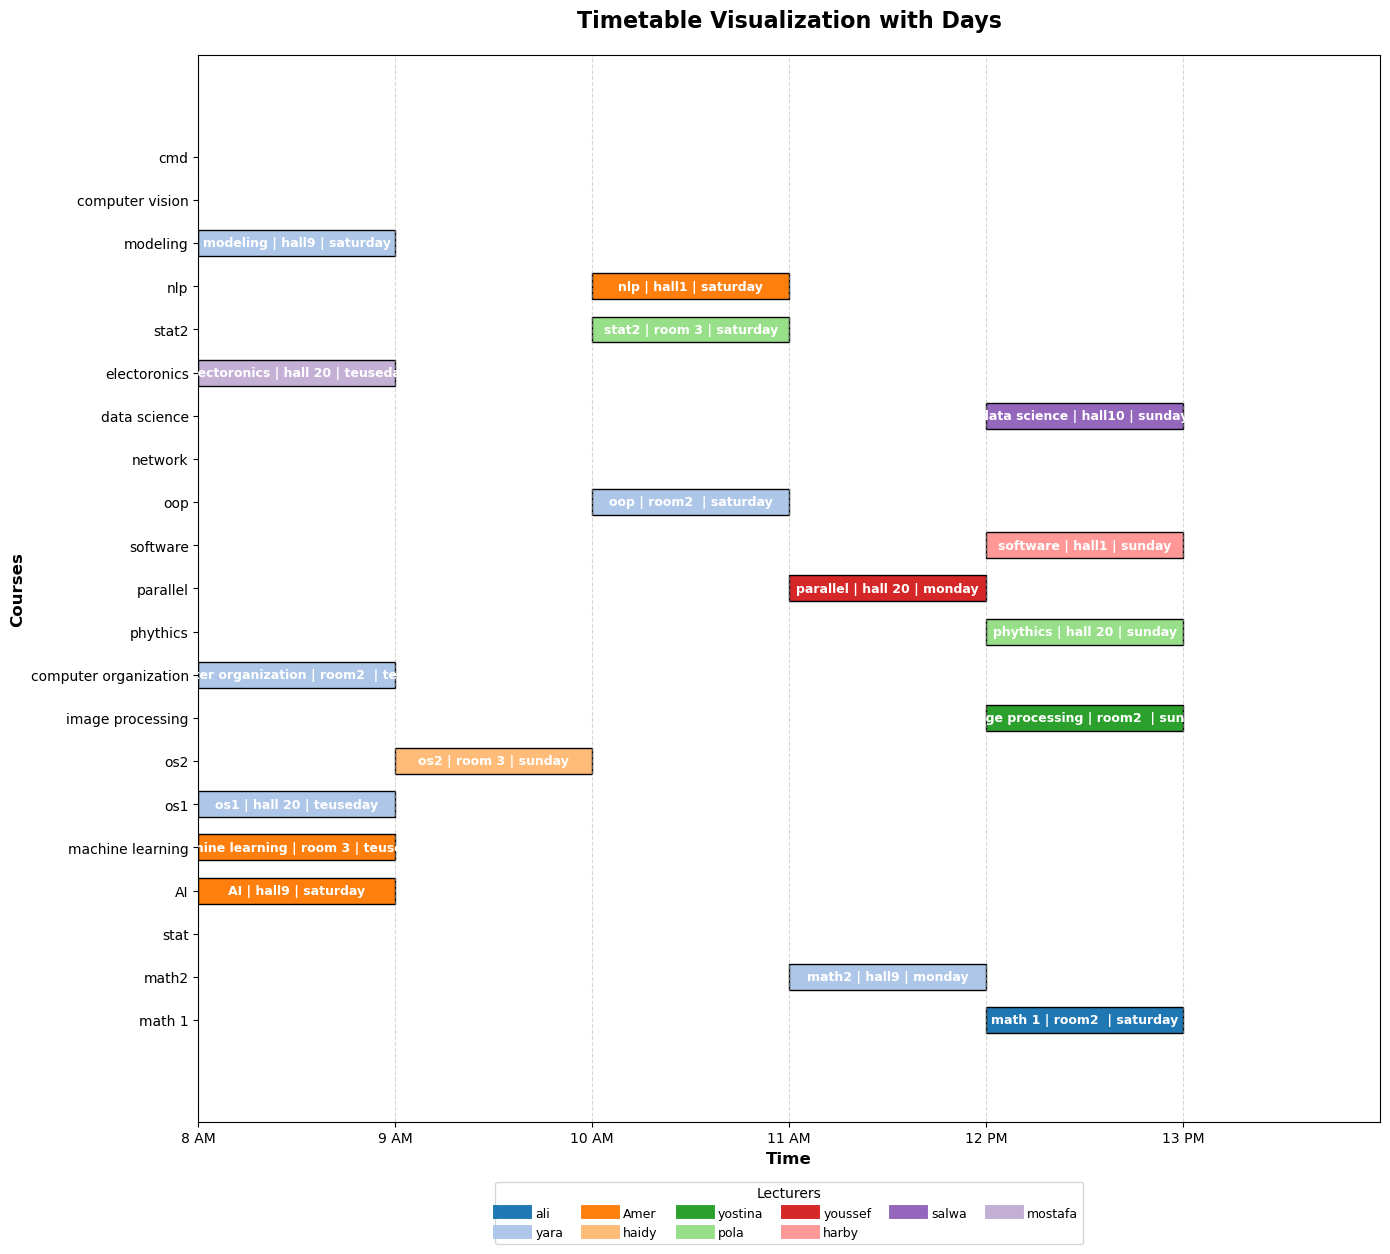

In [22]:
import matplotlib.pyplot as plt

def plot_timetable_with_days(timetable):
    """Visualize the timetable with days using a Gantt chart."""
    num_courses = len(timetable)  # Dynamically adjust plot height
    fig, ax = plt.subplots(figsize=(14, num_courses * 0.6))  # Adjust figure height based on courses

    # Color map for lecturers
    lecturer_colors = {}
    colors = plt.cm.tab20.colors  # Use Matplotlib's distinct 20 colors
    color_index = 0

    bar_height = 0.6  # Control bar height for better spacing
    y_positions = list(range(num_courses))  # Y positions for each course

    # Assign a unique color to each lecturer
    for gene in timetable:
        lecturer = gene[1]
        if lecturer[1] not in lecturer_colors:
            lecturer_colors[lecturer[1]] = colors[color_index]
            color_index = (color_index + 1) % len(colors)

    # Plot timetable
    for idx, gene in enumerate(timetable):
        course, lecturer, room, timeslot = gene

        # Convert time slot to numeric (24-hour format)
        start_hour = timeslot[2]
        if timeslot[3] == "PM" and start_hour != 12:
            start_hour += 12
        duration = 1  # Default duration; adjust if you have varying durations

        # Plot horizontal bar
        ax.barh(
            y_positions[idx], 
            duration,  # Duration (in hours)
            left=start_hour, 
            height=bar_height, 
            color=lecturer_colors[lecturer[1]], 
            edgecolor="black"
        )

        # Add course name, room, and day annotation inside the bar
        ax.text(
            start_hour + 0.5, 
            y_positions[idx], 
            f"{course[1]} | {room[1]} | {timeslot[1]}",  # Include the day (timeslot[1])
            ha="center", va="center", 
            fontsize=9, color="white", fontweight="bold", clip_on=True
        )

    # Configure axes
    ax.set_yticks(y_positions)
    ax.set_yticklabels([gene[0][1] for gene in timetable], fontsize=10, ha="right")
    
    # Set the x-axis range to start from 8 AM (8:00) and end at 8 PM (20:00)
    ax.set_xlim(8, 14)
    
    # Set x-ticks for each hour between 8 AM and 8 PM
    ax.set_xticks(range(8, 14))
    ax.set_xticklabels([f"{hour} {'AM' if hour < 12 else 'PM'}" for hour in range(8, 14)], fontsize=10)
    
    ax.set_xlabel("Time", fontsize=12, fontweight="bold")
    ax.set_ylabel("Courses", fontsize=12, fontweight="bold")
    ax.set_title("Timetable Visualization with Days", fontsize=16, fontweight="bold", pad=20)

    # Add gridlines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.margins(y=0.1)  # Add padding for better spacing

    # Add legend for lecturers
    handles = [plt.Line2D([0], [0], color=color, linewidth=10) for color in lecturer_colors.values()]
    ax.legend(
        handles, 
        lecturer_colors.keys(), 
        title="Lecturers", 
        loc="upper center", 
        bbox_to_anchor=(0.5, -0.05), 
        ncol=6, fontsize=9, title_fontsize=10
    )

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example timetable data
plot_timetable_with_days(best_timetable)


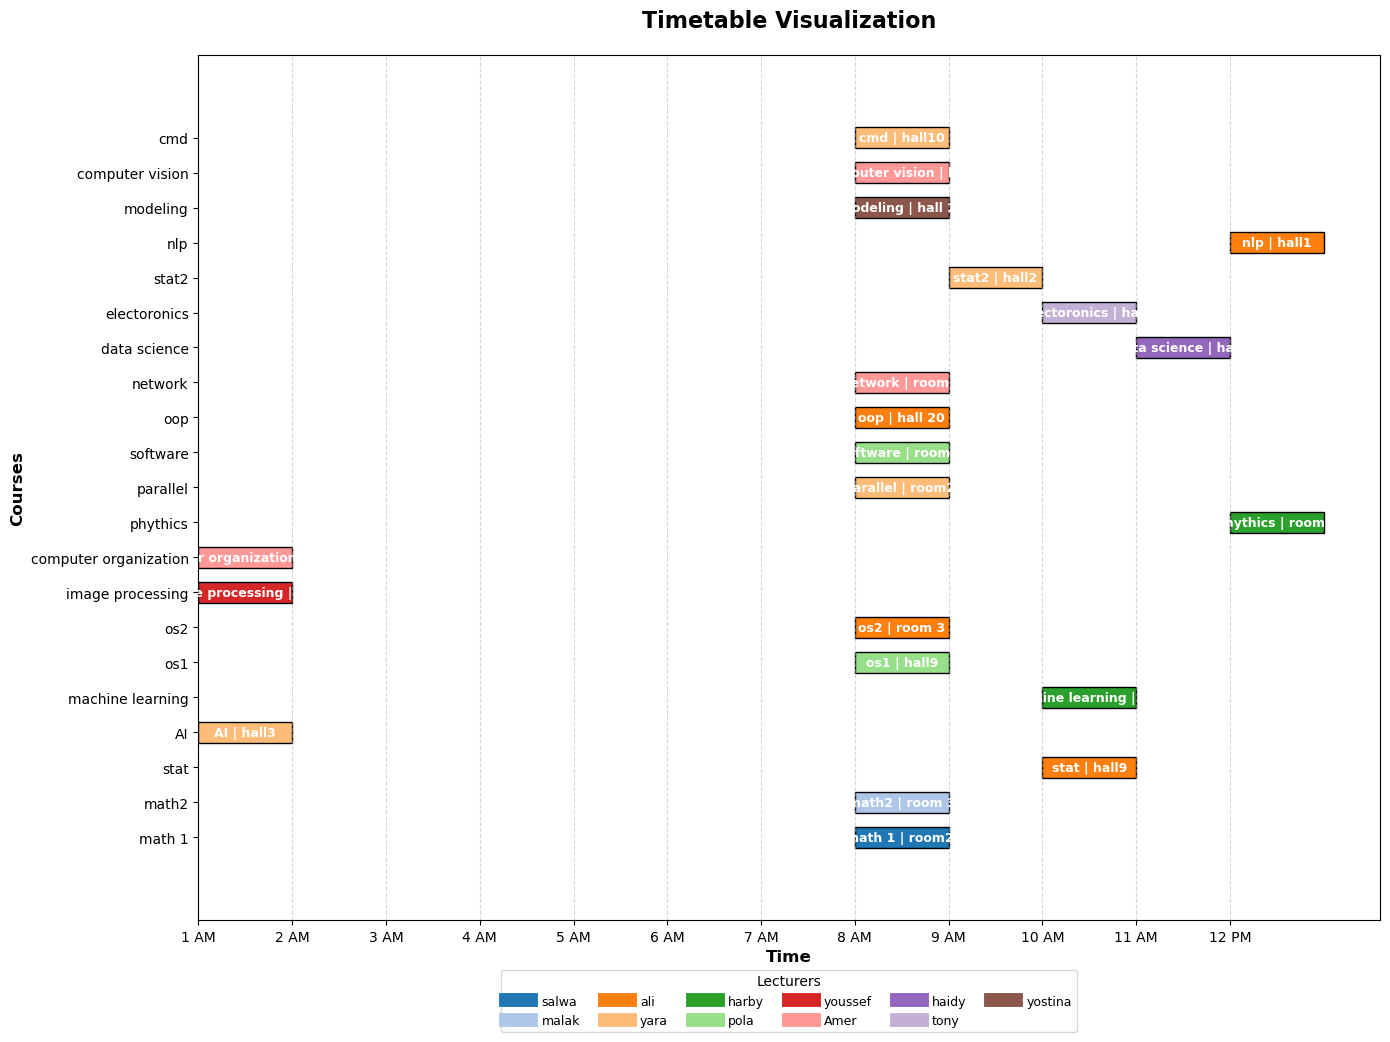

Generation 1: Best Fitness = 0.0106
Generation 2: Best Fitness = 0.0106
Generation 3: Best Fitness = 0.0106
Generation 4: Best Fitness = 0.0106
Generation 5: Best Fitness = 0.0109
Generation 6: Best Fitness = 0.0110
Generation 7: Best Fitness = 0.0095
Generation 8: Best Fitness = 0.0095
Generation 9: Best Fitness = 0.0116
Generation 10: Best Fitness = 0.0137
Generation 11: Best Fitness = 0.0137
Generation 12: Best Fitness = 0.0145
Generation 13: Best Fitness = 0.0123
Generation 14: Best Fitness = 0.0111
Generation 15: Best Fitness = 0.0108
Generation 16: Best Fitness = 0.0092
Generation 17: Best Fitness = 0.0092
Generation 18: Best Fitness = 0.0089
Generation 19: Best Fitness = 0.0123
Generation 20: Best Fitness = 0.0130
Generation 21: Best Fitness = 0.0120
Generation 22: Best Fitness = 0.0110
Generation 23: Best Fitness = 0.0116
Generation 24: Best Fitness = 0.0116
Generation 25: Best Fitness = 0.0120
Generation 26: Best Fitness = 0.0128
Generation 27: Best Fitness = 0.0128
Generation

ValueError: too many values to unpack (expected 2)

In [ ]:
import matplotlib.pyplot as plt

def plot_timetable(timetable):
    """Visualize the timetable using a Gantt chart with improved readability."""
    num_courses = len(timetable)  # Dynamically adjust plot height
    fig, ax = plt.subplots(figsize=(14, num_courses * 0.5))  # Adjust figure height based on courses

    # Color map for lecturers
    lecturer_colors = {}
    colors = plt.cm.tab20.colors  # Use Matplotlib's distinct 20 colors
    color_index = 0

    bar_height = 0.6  # Control bar height for better spacing
    y_positions = list(range(num_courses))  # Y positions for each course

    # Assign a unique color to each lecturer
    for gene in timetable:
        lecturer = gene[1]
        if lecturer[1] not in lecturer_colors:
            lecturer_colors[lecturer[1]] = colors[color_index]
            color_index = (color_index + 1) % len(colors)

    # Plot timetable
    for idx, gene in enumerate(timetable):
        course, lecturer, room, timeslot = gene

        # Convert time slot to numeric
        start_hour = timeslot[2]
        if timeslot[3] == "PM" and start_hour != 12:
            start_hour += 12
        duration = 1  # Default duration; adjust if you have varying durations

        # Plot horizontal bar
        ax.barh(
            y_positions[idx], 
            duration,  # Duration (in hours)
            left=start_hour, 
            height=bar_height, 
            color=lecturer_colors[lecturer[1]], 
            edgecolor="black"
        )

        # Add course name and room annotation inside the bar
        ax.text(
            start_hour + 0.5, 
            y_positions[idx], 
            f"{course[1]} | {room[1]}", 
            ha="center", va="center", 
            fontsize=9, color="white", fontweight="bold", clip_on=True
        )

    # Configure axes
    ax.set_yticks(y_positions)
    ax.set_yticklabels([gene[0][1] for gene in timetable], fontsize=10, ha="right")
    
    # Dynamically set x-ticks from actual timeslots
    time_slots = sorted(set(gene[3][2] for gene in timetable))  # Unique timeslot hours
    ax.set_xticks(range(min(time_slots), max(time_slots) + 1))
    ax.set_xticklabels([f"{hour} {'AM' if hour < 12 else 'PM'}" for hour in range(min(time_slots), max(time_slots) + 1)], fontsize=10)
    
    ax.set_xlabel("Time", fontsize=12, fontweight="bold")
    ax.set_ylabel("Courses", fontsize=12, fontweight="bold")
    ax.set_title("Timetable Visualization", fontsize=16, fontweight="bold", pad=20)

    # Add gridlines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.margins(y=0.1)  # Add padding for better spacing

    # Add legend for lecturers
    handles = [plt.Line2D([0], [0], color=color, linewidth=10) for color in lecturer_colors.values()]
    ax.legend(
        handles, 
        lecturer_colors.keys(), 
        title="Lecturers", 
        loc="upper center", 
        bbox_to_anchor=(0.5, -0.05), 
        ncol=6, fontsize=9, title_fontsize=10
    )

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example timetable data
plot_timetable(best_timetable)

# Plot Fitness vs Generations
def plot_fitness_vs_generations(fitness_history):
    plt.plot(range(1, len(fitness_history) + 1), fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness vs Generations')
    plt.grid(True)
    plt.show()


# Main Program
courses, lecturers, rooms, timeslots = load_data()
if not (courses and lecturers and rooms and timeslots):
    print("Error: Missing or invalid data from the database.")
else:
    best_timetable, fitness_history = genetic_algorithm(POP_SIZE, GENERATIONS, courses, lecturers, rooms, timeslots)
    print("Best Timetable:", best_timetable)
    plot_fitness_vs_generations(fitness_history)  # Plot the relation